<h1 style="font-size:42px; text-align:center; margin-bottom:30px;"><span style="color:SteelBlue">Module 3:</span> Principal Component Analysis</h1>
<hr>

Welcome to <span style="color:royalblue">Module 3: Principal Component Analysis</span>!

Principal Component Analysis, or PCA, is a popular dimensionality reduction technique.

PCA seeks to create new features by finding linear combinations of your original ones. These new features, called **principal components**, are meant to maximize the **"explained variance,"** which we'll explain further in the module.

* In this module, we'll prepare individual item features for our clustering algorithms, except this time we'll use PCA instead of thresholding.
* PCA is especially effective when you have many correlated features.
* Important: PCA creates new features that replace the original ones.


<br><hr id="toc">

### In this module...

In this module, we'll cover:
1. [Toy example: oval blob](#oval-blob)
2. [Principal components](#components)
3. [Dimensionality reduction](#reduction)
4. [Item data PCA](#item-data)
5. [Explained variance](#explained-variance)

<br><hr>

### First, let's import libraries and load the item data.

First, import libraries that you'll need.

In [1]:
# print_function for compatibility with Python 3
from __future__ import print_function

# NumPy for numerical computing
import numpy as np

# Pandas for DataFrames
import pandas as pd

# Matplotlib for visualization
import matplotlib.pyplot as plt

# display plots in the notebook
%matplotlib inline

# Seaborn for easier visualization
import seaborn as sns

# StandardScaler from Scikit-Learn
from sklearn.preprocessing import StandardScaler

# PCA from Scikit-Learn (added later)
from sklearn.decomposition import  PCA

Next, let's import the full item data that we saved in the previous module (before applying thresholds).
* Remember, we saved it as <code style="color:crimson">'item_data.csv'</code>.
* This time, we'll also pass in the argument <code style="color:steelblue">index_col=0</code> to tell Pandas to treat the first column (CustomerID) as the index.

In [2]:
# Read item_data.csv
item_data = pd.read_csv('item_data.csv', index_col=['CustomerID'])
item_data.head()

10002  10120  10125  10133  10135  11001  15034  15036  15039  \
CustomerID                                                                  
12347           0      0      0      0      0      0      0      0      0   
12348           0      0      0      0      0      0      0      0      0   
12349           0      0      0      0      0      0      0      0      0   
12350           0      0      0      0      0      0      0      0      0   
12352           0      0      0      0      0      0      0      0      0   

            15044A  ...   90192  90201A  90201B  90201C  90201D  90202D  \
CustomerID          ...                                                   
12347            0  ...       0       0       0       0       0       0   
12348            0  ...       0       0       0       0       0       0   
12349            0  ...       0       0       0       0       0       0   
12350            0  ...       0       0       0       0       0       0   
12352            0  ...       0       0       0       0       0       0   

            90204  C2  M  POST  
CustomerID                      
12347           0   0  0     0  
12348           0   0  0     4  
12349           0   0  0     1  
12350           0   0  0     1  
12352           0   0  3     5  

[5 rows x 2574 columns]

Just to confirm, this dataset should have 2574 features:

In [3]:
# Display item_data's shape
item_data.shape

(414, 2574)

<span id="oval-blob"></span>
# 1. Toy example: oval blob

PCA is an elegant technique that's very practical, but it can be a bit hard to try it on our larger dataset right away.

Instead, let's first use one last toy example to break down the intuition behind PCA.

<br>
**First, we'll create an "oval blob" synthetic dataset.**
* Instead of both input features and a target variable, we'll only have 2 input features.
* $x_1$ will be random samples from a normal distribution.
* $x_2$ will be random samples from a normal distribution **plus $x_1$**.

In [4]:
# Set random seed
np.random.seed(101)

# Create first feature: x1
x1 = np.random.normal(0,1,100)

# Create second feature: x2
x2 = x1 + np.random.normal(0,1,100)

**Let's stack them together to form <code style="color:steelblue">X</code>, our input feature matrix.**
* We'll skip putting them in a Pandas DataFrame.
* Instead, we'll just stack them together as two separate columns in a matrix.

In [5]:
# Stack together as columns
X = np.column_stack([x1,x2])

# Print shape of X
X.shape

(100, 2)

**Create a scaled version of your feature matrix and name it <code style="color:steelblue">X_scaled</code>.**
* You'll want to use <code style="color:steelblue">StandardScaler</code>.
* **Tip:** To fit and apply a transformation in one line of code, you can use the <code style="color:steelblue">.fit_transform()</code> function.
* Then, display the first 5 rows. 
    * You can't use <code style="color:steelblue">.head()</code> because it's not a dataframe.
    * You must **index/slice the array** instead.

In [6]:
# Initialize instance of StandardScaler
sc = StandardScaler()

# Fit and transform X
X_scaled = sc.fit_transform(X)

# Display first 5 rows of X_scaled
X_scaled[:5]

array([[ 2.45737416,  2.76968241],
       [ 0.44665735, -0.38363275],
       [ 0.71733989, -0.37695455],
       [ 0.3264168 , -0.60579169],
       [ 0.46889068,  0.39146426]])

**Plot a scatterplot of the scaled $x_1$ against the scaled $x_2$.**
* Label your axes as <code style="color:crimson">x1 (scaled)</code> and <code style="color:crimson">x2 (scaled)</code>.
* **Tip:** Call <code style="color:steelblue">plt.axis('equal')</code> after your scatterplot to put your plot's axes on the same scale.
* We have a recommended plot below. See the Answer Key for how to create it.

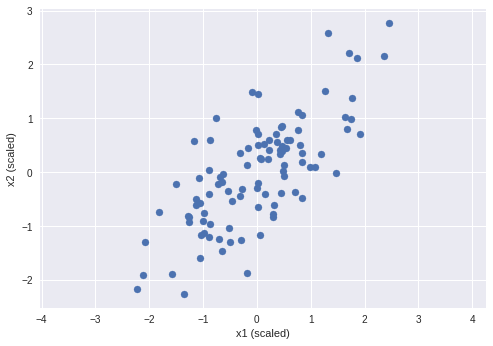

In [7]:
# Plot scatterplot of scaled x1 against scaled x2
plt.scatter(X_scaled[:,0],X_scaled[:,1])

# Put plot axes on the same scale
plt.axis('equal')

# Label axes
plt.xlabel('x1 (scaled)')
plt.ylabel('x2 (scaled)')

# Clear text residue
plt.show()

<p style="text-align:center; margin: 40px 0 40px 0; font-weight:bold">
<a href="#toc">Back to Contents</a>
</p>

<span id="components"></span>
# 2. Principal components

As it turns out, this type of distribution is very helpful for visualizing the mechanics behind PCA.

<br>
**First, add the following import line to your library imports above. Then, re-run that code cell.**

<pre style="color:steelblue">
from sklearn.decomposition import PCA
</pre>

<br>
**Next, we can initialize an instance of the PCA transformation.**
* This is just as we did for the StandardScaler transformation. 
* Then, we can fit the instance with just one line of code.

In [8]:
# Initialize instance of PCA transformation
pca = PCA()

# Fit the instance
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

**Let's display the principal components.**

In [9]:
# Display principal components
pca.components_

array([[ 0.70710678,  0.70710678],
       [-0.70710678,  0.70710678]])

**Next, let's overlay the principal components on our oval blob.**
* We'll make the oval blob semi-transparent so we can see the principal components more easily.
* For clarity, we'll plot the first principal component in **black**, and we'll make it twice as long.
* We'll plot the first principal component in <strong style="color:red">red</strong>.

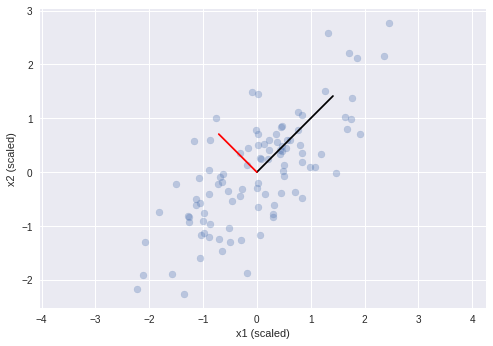

In [10]:
# Plot scaled dataset and make it partially transparent
plt.scatter(X_scaled[:,0], X_scaled[:,1], alpha=0.3)

# Plot first principal component in black
plt.plot([0,2*pca.components_[0,0]],[0,2*pca.components_[0,1]],'k')

# Plot second principal component in red
plt.plot([0,pca.components_[1,0]],[0,pca.components_[1,1]],'r')

# Set axes
plt.axis('equal')
plt.xlabel('x1 (scaled)')
plt.ylabel('x2 (scaled)')

# Clear text residue
plt.show()

**Finally, we can transform our original features using the fitted PCA instance.**
* Remember, PCA generates new features that **replace** the original ones.
* We'll name these new features <code style="color:crimson">PC</code> (short for "principal component") to indicate that they are generated from PCA.

In [11]:
# Generate new features
PC = pca.transform(X_scaled)

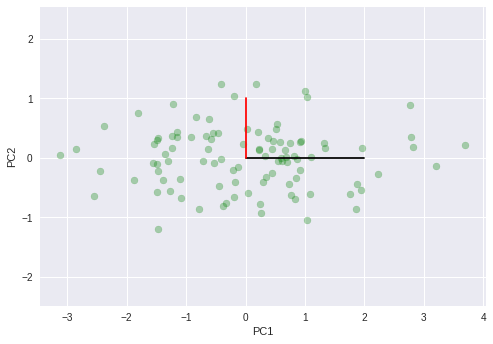

In [12]:
# Plot transformed dataset
plt.scatter(PC[:,0], PC[:,1],alpha=0.3, color='g')

# Plot first principal component in black
plt.plot([0,2],[0,0],'k')


# Plot second principal component in red
plt.plot([0,0],[0,1],'r')


# Set axes
plt.axis('equal')
plt.xlabel('PC1')
plt.ylabel('PC2')

# Clear text residue
plt.show()

<p style="text-align:center; margin: 40px 0 40px 0; font-weight:bold">
<a href="#toc">Back to Contents</a>
</p>

<span id="reduction"></span>
# 3. Dimensionality reduction

Here's where dimensionality reduction comes into play. You can just keep some number of the "best" components, a.k.a. the ones that explain the most variance.

<br>
**First, display the "explained variance" ratio of each component.**

In [13]:
# Display explained variance ratio
pca.explained_variance_ratio_

array([ 0.86915841,  0.13084159])

**To keep only 1 component, we can simply initialize and fit another PCA transformation.**
* This time, we'll simply pass the argument <code style="color:steelblue">n_components=1</code>.

In [14]:
# Initialize and fit a PCA transformation, only keeping 1 component
pca = PCA(n_components=1)
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [15]:
# Display principal components
pca.components_

array([[ 0.70710678,  0.70710678]])

In [16]:
# Generate new features
PC = pca.transform(X_scaled)
print(PC.shape)

(100, 1)


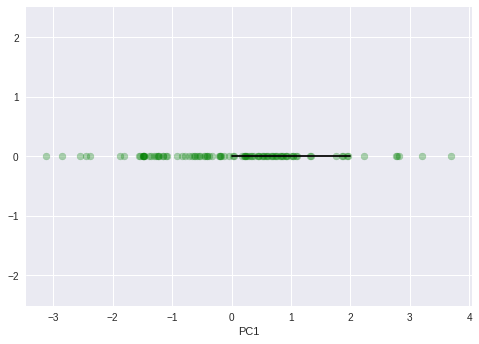

In [17]:
# Plot transformed dataset
plt.scatter(PC[:,0], len(PC)*[0], color='g', alpha=0.3)

# Plot first principal component in black
plt.plot([0,2], [0,0],'k')

# Set axes
plt.axis('equal')
plt.xlabel('PC1')

# Clear text residue
plt.show()

<p style="text-align:center; margin: 40px 0 40px 0; font-weight:bold">
<a href="#toc">Back to Contents</a>
</p>

<span id="item-data"></span>
# 4. Item data PCA

Now let's get back to our project.

<br>
**First, scale <code style="color:crimson">item_data</code>, which you imported at the beginning of this module.**
* Name the scaled dataset <code style="color:crimson">item_data_scaled</code>.
* Then, display the first 5 rows. 
    * You can't use <code style="color:steelblue">.head()</code> because it's not a dataframe.
    * You must **index/slice the array** instead.

In [18]:
# Initialize instance of StandardScaler
sc = StandardScaler()

# Fit and transform item_data
item_data_scaled = sc.fit_transform(item_data)

# Display first 5 rows of item_data_scaled
item_data_scaled[:5]

array([[-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183, -0.68068072],
       [-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183,  0.38776219],
       [-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183, -0.41356999],
       [-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183, -0.41356999],
       [-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
         5.53128397,  0.65487292]])

**Next, initialize and fit an instance of the PCA transformation.**
* Keep all of the components for now (just don't pass in any argument).

In [19]:
# Initialize and fit a PCA transformation
pca = PCA()

**Finally, generate new "principal component features" from <code style="color:crimson">item_data_scaled</code>.**
* Name the new array <code style="color:crimson">PC_items</code>.
* Then, display the first 5 rows.

In [20]:
# Generate new features
PC = pca.fit_transform(item_data_scaled)

# Display first 5 rows
PC[:5]

array([[  5.87614052e+00,   4.82891689e+00,  -4.95545069e-01, ...,
         -6.62646278e-04,  -4.43629806e-05,   4.08162129e-15],
       [ -4.21983747e+00,   1.22621722e+00,  -1.88191211e+00, ...,
         -2.11471782e-04,  -2.69154340e-04,   4.08162129e-15],
       [ -1.26084676e+00,   2.38766371e+00,  -7.31483440e-02, ...,
          2.57750179e-04,  -2.05682324e-04,   4.08162129e-15],
       [ -4.92931983e+00,  -7.14858724e-01,  -1.58093026e+00, ...,
         -1.98603886e-03,   9.92316312e-05,   4.08162129e-15],
       [ -2.05311348e+00,   2.11095022e+00,   1.84807021e-01, ...,
         -3.43415269e-04,  -1.32981672e-04,   4.08162129e-15]])

<p style="text-align:center; margin: 40px 0 40px 0; font-weight:bold">
<a href="#toc">Back to Contents</a>
</p>

<span id="explained-variance"></span>
# 5. Explained variance

Earlier, we already saw how to display the **explained variance ratio** for each of the principal components.

<br>
**It's very helpful to calculate and plot the <u>cumulative</u> explained variance.**
* This will tell us the total amount of variance we'd capture if we kept up to the n-th component.
* First, we'll use <code style="color:steelblue">np.cumsum()</code> to calculate the cumulative explained variance.
* Then, we'll plot it so we can see how many $PC$ features we'd need to keep in order to capture most of the original variance.

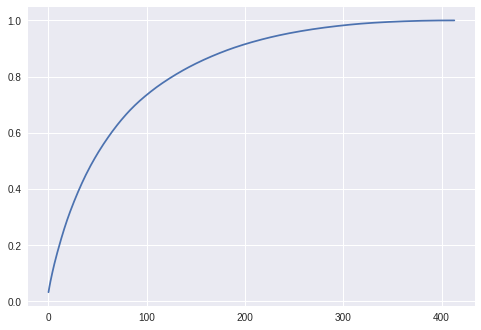

In [21]:
# Cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.plot(range(len(cumulative_explained_variance)), cumulative_explained_variance)
plt.show()

In [22]:
# How much variance we'd capture with the first 125 components
cumulative_explained_variance[125]

0.79771648394418848

**Initialize and fit another PCA transformation.**
* This time, only keep 125 components.
* Generate the principal component features from the fitted instance and name the new matrix <code style="color:crimson">PC_items</code>.
* Then, display the shape of <code style="color:crimson">PC_items</code> to confirm it only has 125 features.

In [23]:
# Initialize PCA transformation, only keeping 125 components
pca = PCA(n_components=125)

# Fit and transform item_data_scaled
PC_items = pca.fit_transform(item_data_scaled)

# Display shape of PC_items
PC_items.shape

(414, 125)

**Next, for convenience, let's put <code style="color:crimson">PC_items</code> into a new dataframe.**
* We'll also name the columns and update its index to be the same as the orginal <code style="color:crimson">item_data</code>'s index.

In [24]:
# Put PC_items into a dataframe
items_pca = pd.DataFrame(PC_items)

# Name the columns
items_pca.columns = ['PC{}'.format(i+1) for i in range(items_pca.shape[1])]

# Update its index
items_pca.index = item_data.index

# Display first 5 rows
items_pca.head(5)

PC1       PC2       PC3       PC4       PC5        PC6  \
CustomerID                                                                
12347       5.876141  4.828892 -0.495543  3.093843 -0.633702 -11.534085   
12348      -4.219839  1.226195 -1.881922 -0.174302  0.817768   1.160852   
12349      -1.260838  2.387828 -0.073097 -1.118903 -0.034546  -3.715325   
12350      -4.929319 -0.714874 -1.581119 -0.469789 -0.116164   0.647736   
12352      -2.053129  2.110788  0.184844  0.128379  0.087133  -1.943497   

                 PC7       PC8       PC9      PC10    ...        PC116  \
CustomerID                                            ...                
12347       2.161913  7.116797  5.336110  4.424089    ...    -0.007766   
12348      -0.871961 -0.846827  0.460120  0.854323    ...    -1.904435   
12349      -0.342738 -0.149002 -0.789685 -0.377883    ...     4.595645   
12350       0.112682 -1.336327  1.547287 -1.190830    ...    -1.869817   
12352       2.383475  0.898283 -0.672848  0.081181    ...     1.695937   

               PC117      PC118     PC119     PC120     PC121     PC122  \
CustomerID                                                                
12347      -0.779199   0.613359 -0.330509 -0.004962 -0.045697  0.148163   
12348       0.075644  -0.955823  1.409611  0.724342  0.464916  1.907702   
12349      -4.527504  -2.370799 -3.396166 -3.419379 -1.304617  3.845541   
12350      -0.460085  -1.192275 -0.596812 -0.808693  0.373854 -0.282510   
12352       8.096258  10.325739 -8.947321 -3.582689 -2.078227  3.346192   

               PC123     PC124     PC125  
CustomerID                                
12347      -0.061750 -0.198612 -0.269058  
12348      -1.416770  1.121250 -2.946993  
12349       0.807568 -4.652684  2.594639  
12350      -0.819361 -1.010051  0.363232  
12352       5.183793  0.928319 -1.933235  

[5 rows x 125 columns]

**Finally, save this item dataframe with PCA features as <code style="color:crimson">'pca_item_data.csv'</code>.**
* In <span style="color:royalblue">Module 4</span>, we'll compare the clusters made from using these features against those in <code style="color:crimson">'threshold_item_data.csv'</code>.
* Do **not** set <code style="color:steelblue">index=None</code> because we want to keep the CustomerID's as the index.

In [25]:
# Save pca_item_data.csv
items_pca.to_csv('pca_item_data.csv')

<p style="text-align:center; margin: 40px 0 40px 0; font-weight:bold">
<a href="#toc">Back to Contents</a>
</p>

<br>
## Next Steps

Congratulations for making it through Project 4's Principal Component Analysis!

As a reminder, here are a few things you did in this module:
* You saw how PCA works on an oval blob.
* You contrasted plots of the original features against plots of the principal component features.
* You learned how to intepret cumulative explained variance.
* And you reduced the dimensionality of the item dataset using PCA.

In the next module, <span style="color:royalblue">Module 4: Cluster Analysis</span>, we'll see how different feature sets lead to different clusters. We'll apply K-Means clustering to the analytical base table, the threshold item features, and the PCA item features.

<p style="text-align:center; margin: 40px 0 40px 0; font-weight:bold">
<a href="#toc">Back to Contents</a>
</p>